In [1]:
import SiemensQuadraProperties as sqp
import ExplorerProperties as ep
from ActivityTools import *
from SimulationDataset import *

import matplotlib.pyplot as mpl
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "upper left",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

#Fix random seed for reproducibility, or skip this to allow the results to vary
import random
random.seed( 1234 )

Calculate NECR versus time as an F18 linear source decays from an initial 1100MBq activity (plotted activity is divided by the cylindrical phantom volume in cc).

Statistical fluctuation of the result can be reduced by increasing the simulationWindow parameter, at the cost of CPU time. The size of the simulated dataset can also be increased, but this has a lesser effect for counting experiments.

The CreateDataset command will run the Geant4 simulation with the appropriate parameters for source and detector type and length. The requested number of events will be simulated, but only those within the specified energy window will be loaded for analysis. If a suitable dataset already exists it will be re-used without further simulation.

In [3]:
def NECRatTimeF18( tracerData, crystalData, crystalActivity, detectorRadius,
                  phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9, zWindow=325.0,
                  EnergyResolution=0.0, TimeResolution=0.0 ):

    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    truesAtTime = []
    rPlusSAtTime = []
    scattersAtTime = []
    randomsAtTime = []
    necrStatAtTime = []
    truesStatAtTime = []
    rPlusSStatAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 1100E6, timeSec )

        necr, trues, rPlusS, Scatters, Randoms = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData],
                                                   simulationWindow, coincidenceWindow, detectorRadius,
                                                   ZMin=-zWindow, ZMax=zWindow, UsePhotonTime=True,
                                                   EnergyResolution=EnergyResolution, TimeResolution=TimeResolution )
        necrAtTime.append( necr )
        truesAtTime.append( trues )
        rPlusSAtTime.append( rPlusS )
        scattersAtTime.append( Scatters )
        randomsAtTime.append( Randoms )
        activityAtTime.append( activity / phantomVolume )

    return activityAtTime, necrAtTime, truesAtTime, rPlusSAtTime, scattersAtTime, randomsAtTime

# Simulation parameters
phantomLength = 700
datasetSize = 1000000
siemensEmin = 435.0
siemensEmax = 585.0
explorerEmin = 430.0
explorerEmax = 645.0

# Nominal
detectorMaterial = "LSO"
tracerDataSiemens = CreateDataset( 1024, "Siemens", phantomLength, "LinearF18", datasetSize, siemensEmin, siemensEmax, detectorMaterial )
crystalDataSiemens = CreateDataset( 1024, "Siemens", phantomLength, "Siemens", datasetSize, siemensEmin, siemensEmax, detectorMaterial )
activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens, scatterAtTimeSiemens, randomAtTimeSiemens = NECRatTimeF18(
    tracerDataSiemens, crystalDataSiemens, sqp.Lu176decaysInMass( sqp.DetectorMass(detectorMaterial) ), sqp.DetectorRadius(),
    phantomLength )
mpl.clf()

detectorMaterial = "LYSO"
tracerDataExplorer = CreateDataset( 1850, "Explorer", phantomLength, "LinearF18", datasetSize, explorerEmin, explorerEmax, detectorMaterial )
crystalDataExplorer = CreateDataset( 1850, "Explorer", phantomLength, "Explorer", datasetSize, explorerEmin, explorerEmax, detectorMaterial )
activityAtTimeExplorer, necrAtTimeExplorer, trueAtTimeExplorer, rPlusSAtTimeExplorer, scatterAtTimeExplorer, randomAtTimeExplorer = NECRatTimeF18(
    tracerDataExplorer, crystalDataExplorer, ep.Lu176decaysInMass( ep.DetectorMass(detectorMaterial) ), ep.DetectorRadius(),
    phantomLength )
mpl.clf()

Re-using previous simulation
347905.0 events loaded (1000000 simulated) with average 1.1452436728417241 hits/event
Re-using previous simulation
107818.0 events loaded (1000000 simulated) with average 1.0077630822311674 hits/event
Re-using previous simulation
397277.0 events loaded (1000000 simulated) with average 1.1565507190197268 hits/event
Re-using previous simulation
233684.0 events loaded (1000000 simulated) with average 1.0006675681689803 hits/event


<Figure size 640x480 with 0 Axes>

Compare the results for both Siemens Quadra and EXPLORER detectors at their default aFOV values, for a 700mm phantom.

Note that the NEMA NU 2-2012 standard specifies a 650mm window from which to accept hits

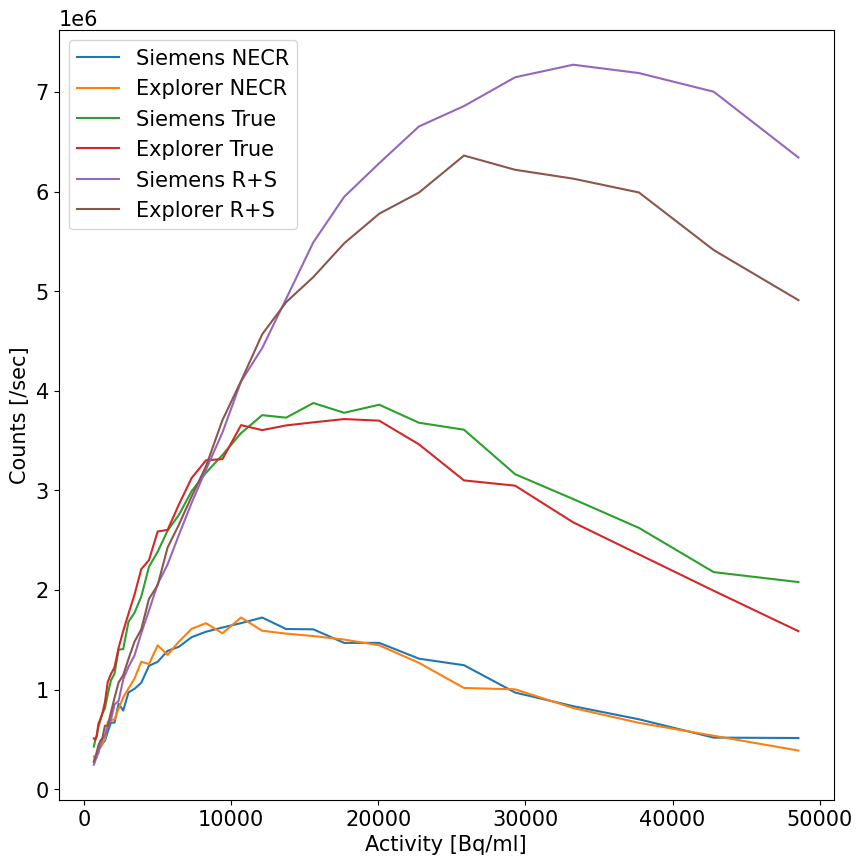

In [4]:
labels = [ "Siemens NECR", "Explorer NECR", "Siemens True", "Explorer True", "Siemens R+S", "Explorer R+S" ]
mpl.plot( activityAtTimeSiemens, necrAtTimeSiemens, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrAtTimeExplorer, label=labels[1] )
mpl.plot( activityAtTimeSiemens, trueAtTimeSiemens, label=labels[2] )
mpl.plot( activityAtTimeExplorer, trueAtTimeExplorer, label=labels[3] )
mpl.plot( activityAtTimeSiemens, rPlusSAtTimeSiemens, label=labels[4] )
mpl.plot( activityAtTimeExplorer, rPlusSAtTimeExplorer, label=labels[5] )
mpl.legend( labels )
mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
mpl.gcf().set_size_inches(10, 10)
mpl.show()

Calculate an error envolope by including the resolution effects in pseudoexperiments

Re-run the experiment 5 times at each working point, with the resolution applying a gaussian-distributed offset to each photon's energy and detection time. Uses multiprocessing.

Results are plotted as a range from highest to lowest value at each working point, with the nominal value being the mean.

In [5]:
import multiprocessing as mp
mp.set_start_method('fork')
from multiprocessing import Pool
import numpy as np

def CreateErrorEnvelope( tracerData, crystalData, crystalActivity, detectorRadius,
                         phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9, processes=5,
                         EnergyResolution=0.0, TimeResolution=0.0 ):
    
    # Create the arguments for each process
    arguments = []
    for experiment in range(10):
        arguments.append( ( tracerData, crystalData, crystalActivity, detectorRadius,
                            phantomLength, simulationWindow, coincidenceWindow, 325.0,
                            EnergyResolution, TimeResolution ) )
    
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( NECRatTimeF18, arguments )
    
    # Unpack the results
    necrEnvelope = []
    trueEnvelope = []
    rPlusSEnvelope = []
    scatterEnvelope = []
    randomEnvelope = []
    for entry in result:
        necrEnvelope.append( entry[1] )
        trueEnvelope.append( entry[2] )
        rPlusSEnvelope.append( entry[3] )
        scatterEnvelope.append( entry[4] )
        randomEnvelope.append( entry[5] )
    return result[0][0], np.transpose( necrEnvelope ), np.transpose( np.array(trueEnvelope) ), np.transpose( np.array(rPlusSEnvelope) ), np.transpose( np.array(scatterEnvelope) ), np.transpose( np.array(randomEnvelope) )

detectorMaterial = "LSO"
activityAtTimeSiemens, necrEnvelopeSiemens, trueEnvelopeSiemens, rPlusSEnvelopeSiemens, scatterEnvelopeSiemens, randomEnvelopeSiemens = CreateErrorEnvelope(
    tracerDataSiemens, crystalDataSiemens, sqp.Lu176decaysInMass( sqp.DetectorMass(detectorMaterial) ),
    sqp.DetectorRadius(), phantomLength, EnergyResolution=0.1, TimeResolution=0.5 )

detectorMaterial = "LYSO"
activityAtTimeExplorer, necrEnvelopeExplorer, trueEnvelopeExplorer, rPlusSEnvelopeExplorer, scatterEnvelopeExplorer, randomEnvelopeExplorer = CreateErrorEnvelope(
    tracerDataExplorer, crystalDataExplorer, ep.Lu176decaysInMass( ep.DetectorMass(detectorMaterial) ),
    ep.DetectorRadius(), phantomLength, EnergyResolution=0.1, TimeResolution=0.5 )

In [6]:
def GetMinMaxFromEnvelope( envelope ):
    
    allMax = []
    allMin = []
    allMean = []
    for entry in envelope:
        allMax.append( max(entry) )
        allMin.append( min(entry) )
        allMean.append( np.mean(entry) )

    return allMin, allMax, allMean

necrMinSiemens, necrMaxSiemens, necrMeanSiemens = GetMinMaxFromEnvelope( necrEnvelopeSiemens )
trueMinSiemens, trueMaxSiemens, trueMeanSiemens = GetMinMaxFromEnvelope( trueEnvelopeSiemens )
rPlusSMinSiemens, rPlusSMaxSiemens, rPlusSMeanSiemens = GetMinMaxFromEnvelope( rPlusSEnvelopeSiemens )

necrMinExplorer, necrMaxExplorer, necrMeanExplorer = GetMinMaxFromEnvelope( necrEnvelopeExplorer )
trueMinExplorer, trueMaxExplorer, trueMeanExplorer = GetMinMaxFromEnvelope( trueEnvelopeExplorer )
rPlusSMinExplorer, rPlusSMaxExplorer, rPlusSMeanExplorer = GetMinMaxFromEnvelope( rPlusSEnvelopeExplorer )

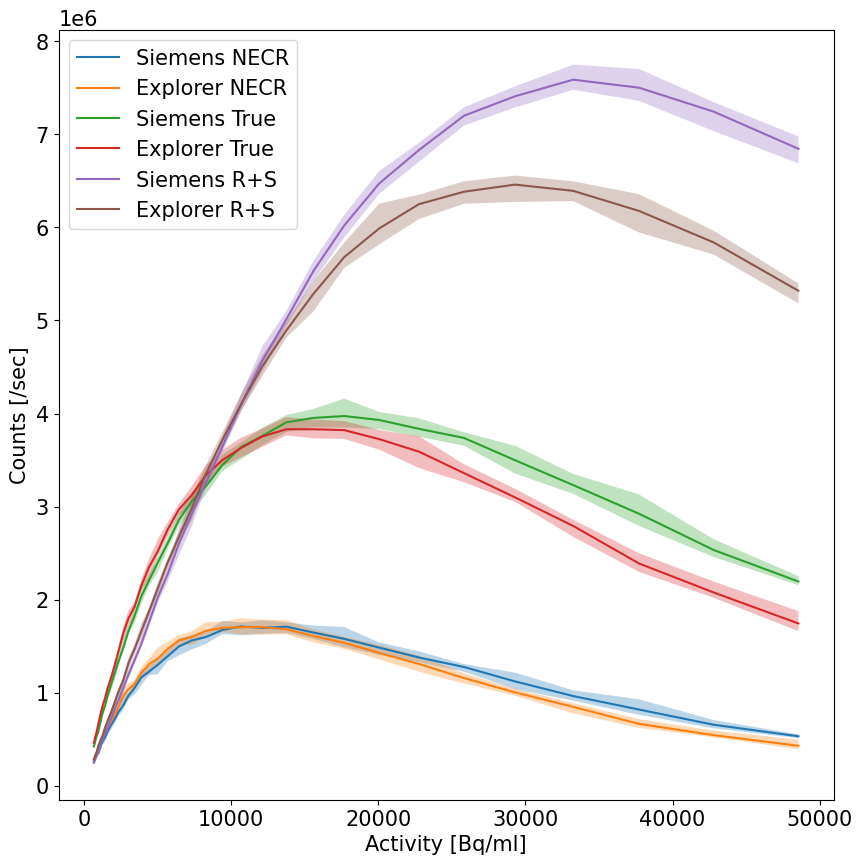

In [7]:
labels = [ "Siemens NECR", "Explorer NECR", "Siemens True", "Explorer True", "Siemens R+S", "Explorer R+S" ]
mpl.plot( activityAtTimeSiemens, necrMeanSiemens, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrMeanExplorer, label=labels[1] )
mpl.plot( activityAtTimeSiemens, trueMeanSiemens, label=labels[2] )
mpl.plot( activityAtTimeExplorer, trueMeanExplorer, label=labels[3] )
mpl.plot( activityAtTimeSiemens, rPlusSMeanSiemens, label=labels[4] )
mpl.plot( activityAtTimeExplorer, rPlusSMeanExplorer, label=labels[5] )
mpl.legend( labels )

mpl.fill_between( activityAtTimeSiemens, necrMinSiemens, necrMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, necrMinExplorer, necrMaxExplorer, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, trueMinSiemens, trueMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, trueMinExplorer, trueMaxExplorer, alpha=0.3 )
mpl.fill_between( activityAtTimeSiemens, rPlusSMinSiemens, rPlusSMaxSiemens, alpha=0.3 )
mpl.fill_between( activityAtTimeExplorer, rPlusSMinExplorer, rPlusSMaxExplorer, alpha=0.3 )

mpl.xlabel( "Activity [Bq/ml]" )
mpl.ylabel( "Counts [/sec]" )
mpl.gcf().set_size_inches(10, 10)
mpl.show()